In [2]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import math
import numpy as np
import matplotlib.pyplot as plt

%env OOMMFTCL=/home/sellmyer/aullah8/.conda/envs/ubermag_env/opt/oommf/oommf.tcl

env: OOMMFTCL=/home/sellmyer/aullah8/.conda/envs/ubermag_env/opt/oommf/oommf.tcl


In [6]:
mu0   = 4.0 * np.pi * 10**-7  # vacuum permeability             N/A^2
Ms    = 1.82/mu0                # saturation magnetisation        A/m
A     = 10e-12              # exchange coupling strength      J/m
Km    = mu0 * Ms**2     # magnetostatic energy density    kg/ms^2
lexch = (A/Km)**0.5   
Rcoey = (24)**0.5*lexch #needle
Rcoh = 5.05*lexch #needle
print(Ms)
print(lexch)
print(Rcoey)
print(Rcoh)

1448309.9821362477
1.947751484511556e-09
9.541994565603528e-09
9.836144996783357e-09


9.73875742255778e-10
200000.0
1.5582011876092448e-08


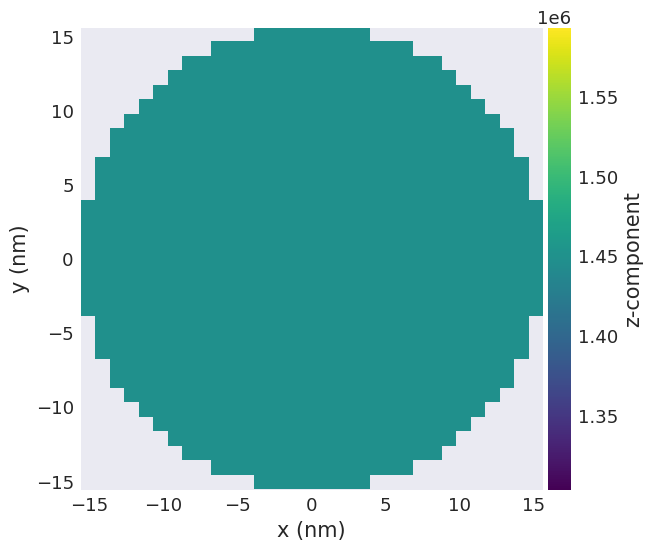

In [5]:
K1    = 20e4
u = (0, 0, 1)
N = 16
r = 8*lexch  # cube edge length (m) I had vortex at 9.7*lexch and z=-5r tpo 5r
cellsize = r/N  # discretisation in all three dimensions.
p1 = (-r, -r, -r)  # Minimum sample coordinate.
p2 = (r, r,r)  # Maximum sample coordinate.
cell = (cellsize, cellsize, cellsize)  # Discretisation.
mesh = df.Mesh(p1=p1, p2=p2, cell=(cellsize, cellsize, cellsize))  # Create a mesh object.

system = mm.System(name='CoFinal')

system.energy = mm.Exchange(A=A) + mm.UniaxialAnisotropy(K=K1, u=u) + mm.Demag()+mm.Zeeman(H=(0, 0, 0))

flower_init = (0, 0, 1)
def vortex_init(pos):
    x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
    rho = x**2 + y**2
    phi = math.atan(x/y)
    b = 2*lexch
    m_phi = np.sin(2 * np.arctan(rho/b))
    return np.array([-m_phi*np.sin(phi), m_phi*np.cos(phi) , np.sqrt(1.0 - m_phi**2)])

def Ms_value(pos):
    x, y, z =  pos
    if x**2 + y**2  +z**2 < r**2:
        return Ms
    else:
        return 0
    
system.m = df.Field(mesh, dim=3, value=(0,0,1), norm=Ms_value)
    
print(cellsize)
print(K1)
print(r)
system.m.plane('z').mpl()

In [6]:
md = oc.MinDriver()
md.drive(system, overwrite=True)

evolve = oc.CGEvolver()
md = oc.MinDriver(stopping_mxHxm=0.01)


B1_array = np.arange(-2, +2, 0.06)
B2_array = np.arange(0.2, -0.2, -0.0001)
B_array =  np.append([B1_array], [B2_array])

mz = []
mx = []
my = []
S = []
S1 = []
S2 = []

for B in B2_array:
    # Marijan: This way we update the field.
    system.energy.zeeman.H = (0, 0, B/mm.consts.mu0)
    md.drive(system)
    # Marijan: A bit more cool way to extract the x-average normalised magnetisation :)
    mz.append(system.m.orientation.z.average)
    mx.append(system.m.orientation.x.average)
    my.append(system.m.orientation.y.average)
    m = system.m.orientation.plane(z=0.5*r)
    m1 = system.m.orientation.plane(x=0.5*r)
    m2 = system.m.orientation.plane(y=0.5*r)
    S.append(df.integral(m @ (m.derivative('x') & m.derivative('y')) * df.dx*df.dy) / 4 / 3.14)
    S1.append(df.integral(m1 @ (m1.derivative('y') & m1.derivative('z')) * df.dx*df.dy) / 4 / 3.14)
    S2.append(df.integral(m2 @ (m2.derivative('z') & m2.derivative('x')) * df.dx*df.dy) / 4 / 3.14)

Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (1.1 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.8 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.6 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.6 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.7 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.7 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.6 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.6 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.6 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.6 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.6 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.6 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.6 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.7 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.6 s)
Running OOMMF (TclOOMMFRunner)[2023/07/13 07:29]... (0.7 s)
Running OOMMF (TclOOMMFRunner)[2023/07/1

Text(0, 0.5, 'Q')

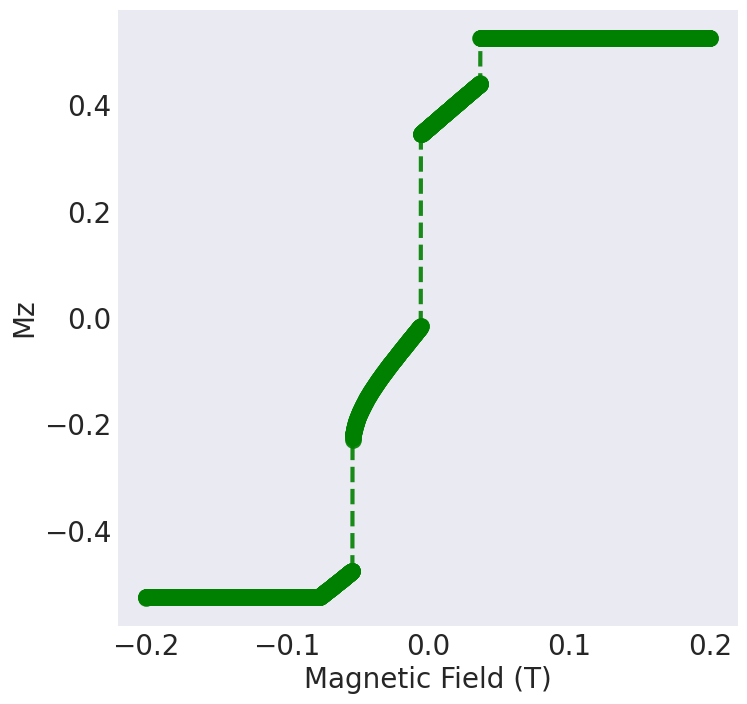

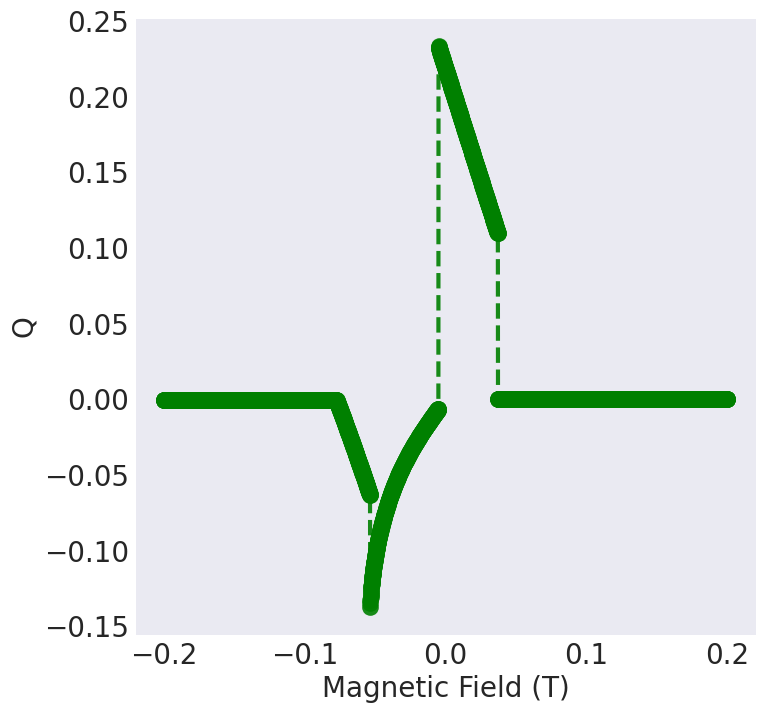

In [28]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,mz, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz', fontsize=20)

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,S, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Q', fontsize=20)

Text(0, 0.5, 'Q')

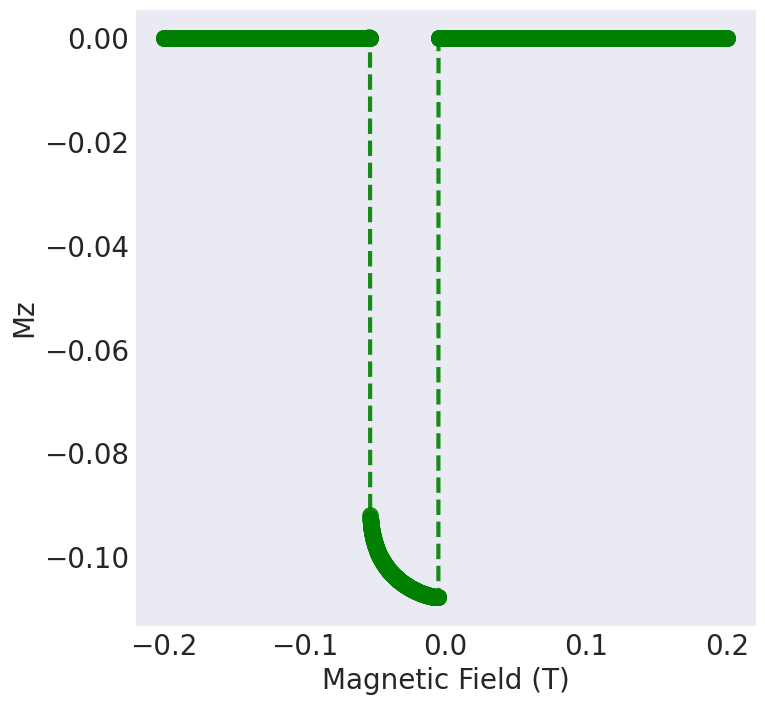

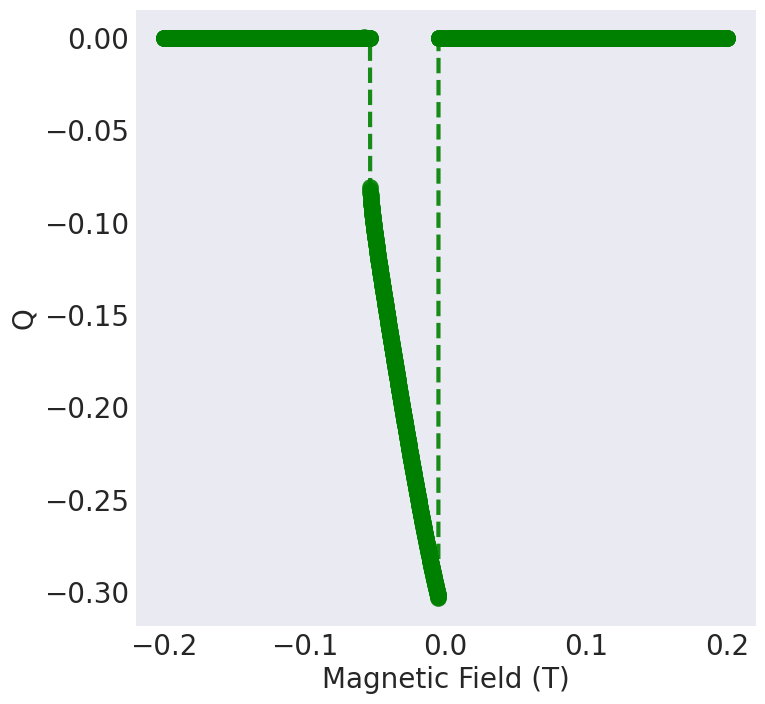

In [8]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,mx, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz', fontsize=20)

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,S1, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Q', fontsize=20)

Text(0, 0.5, 'Q')

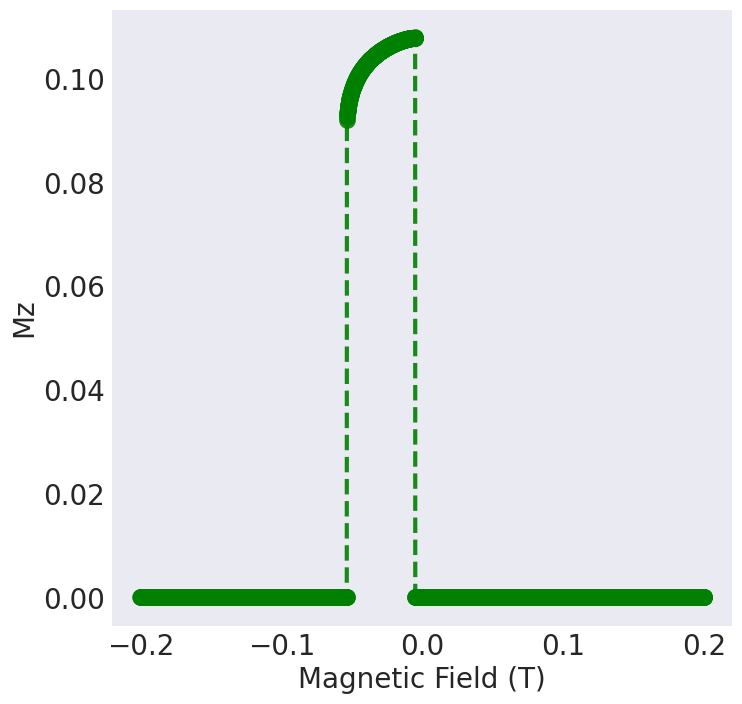

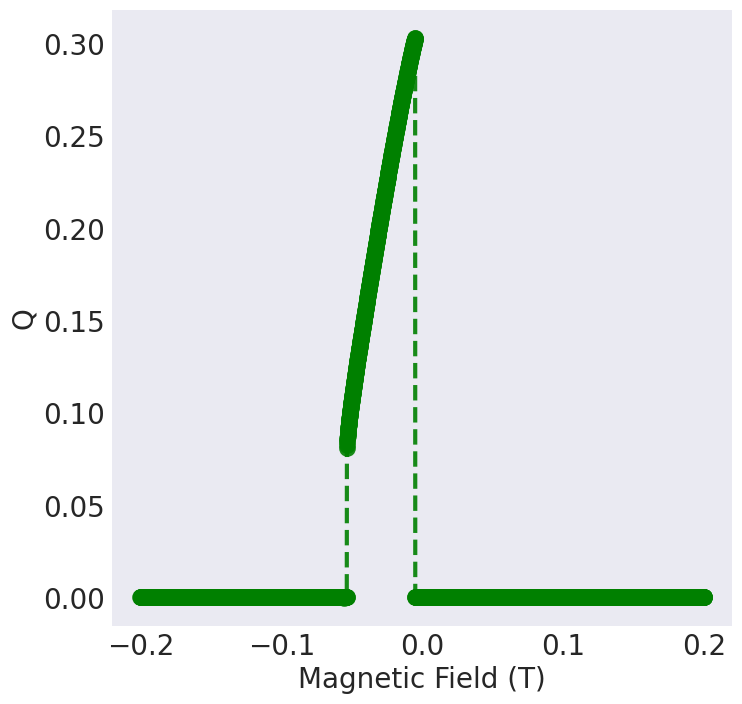

In [9]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,my, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz', fontsize=20)

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B2_array,S2, 'go', linestyle='--',linewidth=3, markersize=12, alpha=0.9, label='M_x2')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Q', fontsize=20)

In [10]:
print(S)

[0.0003110624741746722, 0.00031109631135174096, 0.0003111301358626442, 0.00031116396563698773, 0.00031119780180999083, 0.0003112316441637674, 0.0003112654929365203, 0.0003112993477629271, 0.00031133320838548433, 0.0003113670753788621, 0.00031140094845117717, 0.0003114348271653338, 0.0003114687125256819, 0.00031150260389768366, 0.00031153650171497963, 0.00031157040526480175, 0.00031160431528869976, 0.0003116382311527174, 0.0003116721531647243, 0.0003117060813904928, 0.0003117400159273696, 0.00031177395662999565, 0.0003118079029517504, 0.0003118418561240904, 0.00031187581517302314, 0.0003119097800741259, 0.00031194375145968286, 0.00031197772887602747, 0.0003120117126691268, 0.0003120457024632922, 0.0003120796983255613, 0.0003121137005596363, 0.00031214770882584907, 0.0003121817233589936, 0.00031221574419212705, 0.0003122497707303677, 0.00031228380381135976, 0.000312317842880431, 0.0003123518882931633, 0.00031238593996103293, 0.00031241999754465477, 0.00031245406138991663, 0.0003124881311

In [11]:
print(mz)

[0.5265293970174626, 0.5265293870076941, 0.5265293770031958, 0.5265293669969646, 0.526529356988692, 0.5265293469784402, 0.5265293369662146, 0.5265293269519722, 0.5265293169358474, 0.5265293069177126, 0.5265292968976205, 0.5265292868756224, 0.5265292768515952, 0.5265292668256335, 0.5265292567976106, 0.5265292467677469, 0.5265292367358102, 0.526529226701999, 0.5265292166662039, 0.5265292066284267, 0.5265291965886258, 0.5265291865468558, 0.5265291765032674, 0.5265291664575038, 0.5265291564098388, 0.5265291463603045, 0.5265291363086821, 0.526529126255141, 0.5265291161995405, 0.5265291061420303, 0.5265290960825657, 0.5265290860210584, 0.5265290759576163, 0.5265290658921686, 0.526529055824707, 0.5265290457553986, 0.526529035684009, 0.5265290256106847, 0.5265290155353308, 0.5265290054579876, 0.5265289953787199, 0.526528985297461, 0.5265289752142731, 0.5265289651289985, 0.5265289550417723, 0.526528944952592, 0.526528934861379, 0.5265289247682118, 0.5265289146731245, 0.5265289045759898, 0.52652

In [13]:
B2 = B2_array.tolist()

In [16]:
print(B2)

[0.2, 0.19990000000000002, 0.19980000000000003, 0.19970000000000004, 0.19960000000000006, 0.19950000000000007, 0.19940000000000008, 0.1993000000000001, 0.1992000000000001, 0.1991000000000001, 0.19900000000000012, 0.19890000000000013, 0.19880000000000014, 0.19870000000000015, 0.19860000000000017, 0.19850000000000018, 0.1984000000000002, 0.1983000000000002, 0.1982000000000002, 0.19810000000000022, 0.19800000000000023, 0.19790000000000024, 0.19780000000000025, 0.19770000000000026, 0.19760000000000028, 0.1975000000000003, 0.1974000000000003, 0.1973000000000003, 0.19720000000000032, 0.19710000000000033, 0.19700000000000034, 0.19690000000000035, 0.19680000000000036, 0.19670000000000037, 0.19660000000000039, 0.1965000000000004, 0.1964000000000004, 0.19630000000000042, 0.19620000000000043, 0.19610000000000044, 0.19600000000000045, 0.19590000000000046, 0.19580000000000047, 0.19570000000000048, 0.1956000000000005, 0.1955000000000005, 0.19540000000000052, 0.19530000000000053, 0.19520000000000054,

In [13]:
S[49]

0.0003127267946473537

In [25]:
B22 = str(B2)

In [26]:
print(B22)

[0.2, 0.19990000000000002, 0.19980000000000003, 0.19970000000000004, 0.19960000000000006, 0.19950000000000007, 0.19940000000000008, 0.1993000000000001, 0.1992000000000001, 0.1991000000000001, 0.19900000000000012, 0.19890000000000013, 0.19880000000000014, 0.19870000000000015, 0.19860000000000017, 0.19850000000000018, 0.1984000000000002, 0.1983000000000002, 0.1982000000000002, 0.19810000000000022, 0.19800000000000023, 0.19790000000000024, 0.19780000000000025, 0.19770000000000026, 0.19760000000000028, 0.1975000000000003, 0.1974000000000003, 0.1973000000000003, 0.19720000000000032, 0.19710000000000033, 0.19700000000000034, 0.19690000000000035, 0.19680000000000036, 0.19670000000000037, 0.19660000000000039, 0.1965000000000004, 0.1964000000000004, 0.19630000000000042, 0.19620000000000043, 0.19610000000000044, 0.19600000000000045, 0.19590000000000046, 0.19580000000000047, 0.19570000000000048, 0.1956000000000005, 0.1955000000000005, 0.19540000000000052, 0.19530000000000053, 0.19520000000000054,

In [27]:
from xlsxwriter import Workbook

ModuleNotFoundError: No module named 'xlsxwriter'